<a href="https://colab.research.google.com/github/acse-sf420/ci_mpm/blob/master/%E2%80%9CML_module_coursework_2_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?id=1dtR470-kr9MhA_vytTgnLtdrr5X7HaXu" width="150"/>

### Name: [*Jiachen Feng*]
### CID: [*01905446*]

# Instructions:

Follow the instructions below to complete the coursework and submit it:

1. Read the materials you will need to complete the coursework; you can find them in the github classroom repo provided together with this notebook. The provided materials are: 

  - The paper [*Gradient based learning applied to document recognition*](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) by Yann LeCunn where he describes the original form of the LeNet-5 architecture.

  - The paper [*Visualizing the Loss Landscape of Neural Nets*](https://arxiv.org/pdf/1712.09913.pdf).

  - This Jupyter Notebook template to fill in your answers (it contains some code to assist you).


2. Complete your coursework using this provided Jupyter Notebook template (use Google Colab or your local machine if it has a GPU and/or sufficient computational power).

3. Once you have completed your answers, upload your final notebook to the repo you got from the github classroom link (as you normally do). Make sure to have all the answers in there:

   - **All the cells in your final Jupyter Notebook should be executed before saving and uploading to github in order to have the output of the cells available in the uploaded version** (images you plot, training graphs generated with `livelossplot`, etc). We will not guarantee that if some code blocks are missing we will be able to rerun them for you.

   - Add comments in the code to explain what you are doing at every step. 

   - All answers requiring written answers (ie, not code) should be in markdown blocks in the Jupyter Notebook. This provided Jupyter Notebook template has allocated blocks for the questions, but you can add any coding or markdown blocks that you need.

4. The coursework is released on **Friday 13 May at 15:30h BST**, and the answers have to be submitted on **Saturday  21 May, 23:59h BST**. We will not accept late submissions.

    ***[BST stands for British Summer Time (local UK time)]***

<br>

---
<br>

### The coursework consists of a number of questions/exercises you have to complete. You will find them below.

In [3]:
!pip install pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Imports

In [1]:
# your imports and initial checks here
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## 1-Load the medical MNIST dataset [10 points]
Go to this [kaggle dataset](https://www.kaggle.com/datasets/andrewmvd/medical-mnist/code) and download the data (see provided snippets below).

Format the data as you see fit to use it in your next questions. Explain the process you follow.

[**It is recommended that you convert the images to grayscale using** *torchvision transforms*]

Use the following snippets of code to help you download the data first:

In [3]:
# Get kaggle authentication json
! mkdir ~/.kaggle
# ! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! cp /kaggle.json ~/.kaggle
! ls ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

kaggle.json


In [5]:
# Download and unzip dataset
! kaggle datasets download -d andrewmvd/medical-mnist
! mkdir ./medical-mnist
! unzip -q ./medical-mnist.zip -d medical-mnist

medical-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘./medical-mnist’: File exists
replace medical-mnist/AbdomenCT/000000.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## 2-Plot data [5 points]
Plot 25 images of the training set together with their corresponding label names.






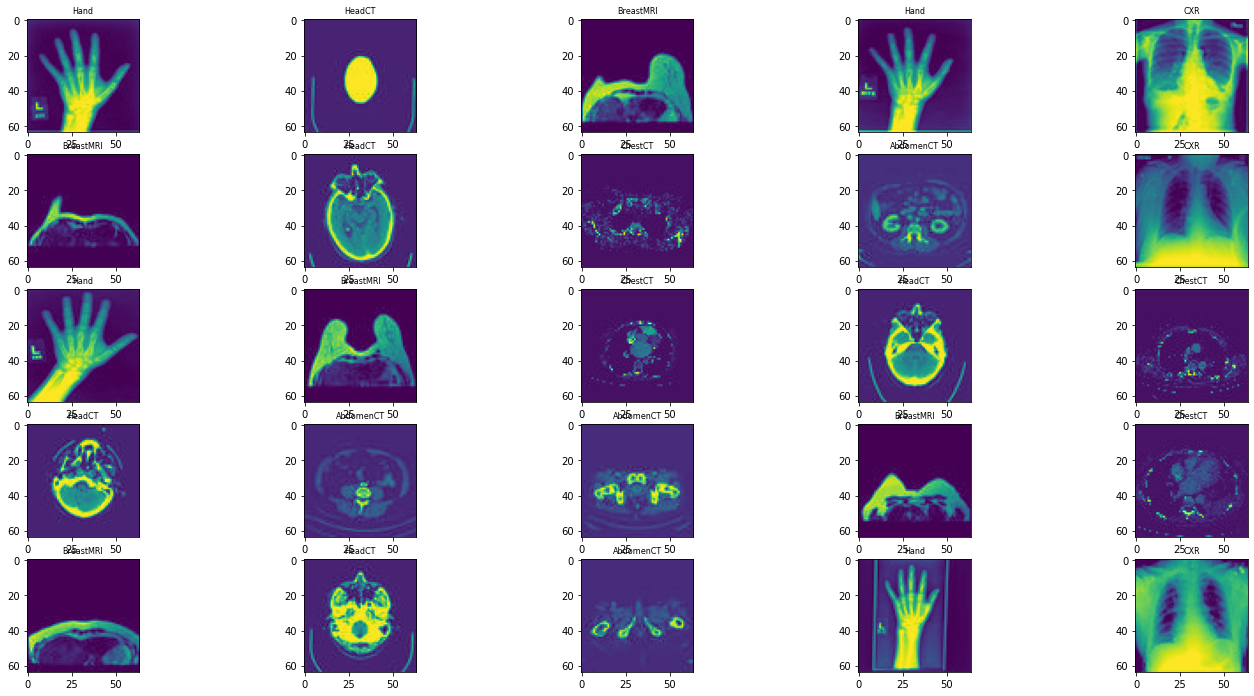

In [2]:
# your code goes here
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import os
import random

class MyData(Dataset):

  def __init__(self, root_dir, label_dir):
    self.root_dir = root_dir
    self.label_dir = label_dir
    self.path = os.path.join(self.root_dir, self.label_dir)
    self.img_path = os.listdir(self.path)

  def __getitem__(self, idx):
    img_name = self.img_path[idx]
    img_item_path = os.path.join(self.root_dir, self.label_dir, img_name)
    img = Image.open(img_item_path)
    pix = np.array(img.getdata()).reshape(img.size[0], img.size[1])
    label = self.label_dir
    return pix, label

  def __len__(self):
    return len(self.img_path)

root_dir = "/content/medical-mnist"
abdomenct_label_dir = "AbdomenCT"
breast_label_dir = "BreastMRI"
cxr_label_dir = "CXR"
chest_label_dir = "ChestCT"
hand_label_dir = "Hand"
head_label_dir = "HeadCT"

abdomenct_dataset = MyData(root_dir, abdomenct_label_dir)
breast_dataset = MyData(root_dir, breast_label_dir)
cxr_dataset = MyData(root_dir, cxr_label_dir)
chest_dataset = MyData(root_dir, chest_label_dir)
hand_dataset = MyData(root_dir, hand_label_dir)
head_dataset = MyData(root_dir, head_label_dir)

train_dataset = abdomenct_dataset + breast_dataset + cxr_dataset + chest_dataset + hand_dataset + head_dataset

fig, axarr = plt.subplots(5, 5, figsize=(24, 12))

for ax in axarr.flatten():
  img, label = train_dataset[random.randint(0, 58954)]
  im = ax.imshow(img)
  ax.set_title(label, fontsize=8)
plt.show()

## 3-Prepare your LeNet-5 network [10 points]
Use the code provided in the Jupyter Notebook template and modify it as you see fit to be able to perform a forward pass using a single dummy tensor input **x**.

Do you need to modify the size of any layers of the network for the Medical MNIST dataset? If yes, explain how you did it and implement the changes.

The lines of code that will do the forward pass and print the network are provided in the template.

In [8]:
from PIL import Image
file_path = "/content/medical-mnist/AbdomenCT/000004.jpeg"
image = Image.open(file_path)
print(image.size)

(64, 64)


In [72]:
#     make modifications in the code below

class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=1) 
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)   
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)   
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*13*13, 120)    
    self.f6 = nn.Linear(120, 84)   
    self.output = nn.Linear(84, 6)  
    self.act = nn.ReLU()           

  def forward(self, x):
    x = self.act(self.c1(x))    
    x = self.act(self.s2(x))   
    x = self.act(self.c3(x))   
    x = self.act(self.s4(x))    
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))     
    x = self.act(self.c5(x))       
    x = self.act(self.f6(x))   
    return self.output(x)          

# Dummy input of the same size as the Medical-MNIST images
x = torch.randn((1, 1, 64, 64)) ## generate a dummy tensor x
model = LeNet5() ## get an instance of your model and call it model
y = model(x) # if you have called your instance something different than model, modify this line of code
print(model)
print(x.shape, y.shape)

LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=2704, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=6, bias=True)
  (act): ReLU()
)
torch.Size([1, 1, 64, 64]) torch.Size([1, 6])


## 4-Create a training, validation split [5 points]
Split the data using `sklearn.model_selection.StratifiedShuffleSplit`:

- 90\% of the data in the training set
- 10\% of the data in the validation set

Verify the stratified shuffle split by plotting a histogram of the classes in the training and validation set.

Prepare the downloaded datasets to be used with your modified network from the previous section.

In [58]:
# your code goes here

from sklearn import preprocessing

train_data_all = []
train_labels_all = []

for id in range(0, 58954):
  train_data, train_label = train_dataset[id]
  # train_data_tensor = torch.from_numpy(train_data)
  # train_data_all[id] = train_data_tensor
  train_data_all.append(train_data)
  train_labels_all.append(train_label)

train_data_all = torch.tensor(train_data_all)
le = preprocessing.LabelEncoder()
targets = le.fit_transform(train_labels_all)
train_label_all = torch.as_tensor(targets)

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1).split(train_data_all, train_label_all) 
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

In [59]:
train_data_all.type
train_label_all.type

<function Tensor.type>

In [60]:
X_train, y_train = train_data_all[indices[0]].float(), train_label_all[indices[0]]
X_val, y_val = train_data_all[indices[1]].float(), train_label_all[indices[1]]

In [61]:
mnist_train = TensorDataset(X_train, y_train.long())
mnist_validate = TensorDataset(X_val, y_val.long())

tensor(91.3800) tensor(71.9635)


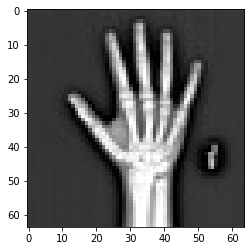

In [62]:
plt.imshow(X_train[0], cmap = 'gray')
print(X_train.mean(), X_train.std())

## 5-Grid search [20 points]
From  the  list  below,  select  two  hyperparameters  and  perform  a  2D  grid-search  to  find  the  optimal values for these two hyperparameters.  The range of values to test are provided.  Justify your choice of the two hyperparameters you want to tune (write a paragraph in a markdown cell explaining why you chose these two particular parameters). 

The list of hyperparameters to choose from is:

a)  Random Number Seed:  **42**  [31, 42, 53] \
b)  Learning Rate:  **1e-2**  [1e-1, 1e-2, 1e-3] \
c)  Momentum:  **0.5**  [0.2, 0.5, 0.8] \
d)  Batch Size:  **64**  [64, 128, 512] \
e)  Number of epochs:  **30**  [10, 30, 50]

The **values in bold** next to each hyperparameter are the values you need to use if you are not tuning this particular hyperparameter.  The values between square brackets are the values to use if you choose to tune this particular hyperparameter. Fixed hyperparameters:

- Optimiser: SGD+momentum
- Test batch size: 1000

Write the results in two tables (one for the loss and one for the accuracy) where the columns and rows are the first and second hyperparameter have selected. You can use markdown tables or create the table in python.

Using *livelossplot* to display the training of some grid-search runs (don't need to plot all of them, choose the ones you think are more relevant to explain your hyperparameter search strategy).

Select the best values for the two hyperparameters you have chosen to optimise and **justify your choice**.

In [64]:
# your code goes here
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30


In [73]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 64, 64))
        #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 64, 64))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 64, 64))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

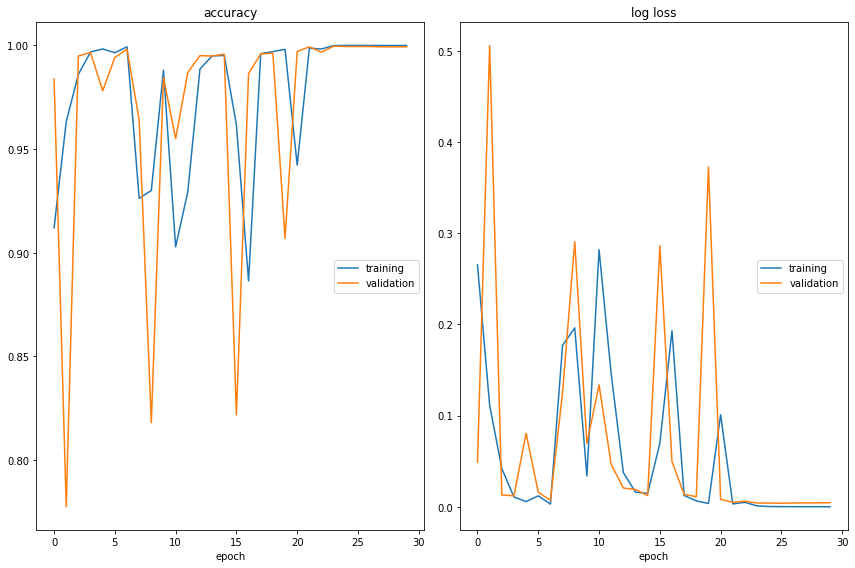

accuracy
	training         	 (min:    0.886, max:    1.000, cur:    1.000)
	validation       	 (min:    0.777, max:    1.000, cur:    0.999)
log loss
	training         	 (min:    0.000, max:    0.282, cur:    0.000)
	validation       	 (min:    0.004, max:    0.506, cur:    0.005)


In [74]:
def train_model(momentum):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
  # test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model

model = train_model(0.5)

## 6-Train with best hyperparameters [5 points]

Once you have your two best hyperparameters, retrain the model by combining your split datasets **as you see fit** and explain why you chose this particular combination. Report the final accuracy on the test set. Use *livelossplot* to plot the values of the training evolution and explain changes in performance with your new combination of datasets.

In [ ]:
# your code goes here

## 7-Comparison with original LeNet implementation  [10 points]}
Read the paper *Gradient based learning applied to document recognition* provided. What are the main differences between their implementation and the one you are using in this coursework?

[**You only need to read and understand the paper until section** III. RESULTS AND COMPARISON WITH OTHER METHODS, *B. Results*, **included, which finishes on page 11 (you can ignore the rest)**]



#### your answers here

## 8-Number of parameters in LeNet-5 [5 points]

Calculate how many trainable parameters the LeNet network you have implemented for this coursework has, and compare it to the number of parameters of the original LeNet network described in the paper you read in the previous question. Explain how you calculate the number of parameters for both cases.

[**answers that only contain the number of parameters without justification will be awarded 0 points**]

In [ ]:
# your code goes here (if you want to use a code cell in this question)

#### your answers here


## 9-Visualising loss landscapes paper - 1 [10 points]

Read the provided paper *Visualising the Loss Landscape of Neural Nets*. This paper contains a lot of advanced concepts, but you only need to read and understand it well up to and including section 4 (Proposed Visualisation: Filter-Wise Normalisation) to answer the questions below. In section 4 you don't need to fully understand the rationale for doing Filter-Wise Normalisation, but you do need to understand what Filter-Wise Normalisation is.

Answer the following question (in a markdown cell):
- What are the dimensions of the parameters $\delta$, $\eta$, $\alpha$ and $\beta$ in equation (1) using your LeNet network? [5 points]
- Describe what is the role of each of these parameters [5 points]

Explain in detail and justify your answers.

## 10-Visualise loss landscapes - 2 [20 points]

Use the formula described in equation (1) in the paper in combination with the Filter-Wise Normalisation to generate landscape plots in these two cases:
- your final trained model (output of question *6*).
- your randomly initialised model.

In both cases, use 25 values for $\alpha$ and 25 values for $\beta$ to generate a 2D plot with 625 points.

Use the provided snippets of code in the Jupyter Notebook template to assist you in generating the plots and to guide you in the functions you will need to implement.

Analyse, compare and discuss your plots. How are they different? and why? Justify the choices you make along the generation process of plotting the loss landscapes (for example, but not limited to, the range your choose for your $\alpha$ and $\beta$ values).

[**you can use a subset of the data to generate the plots, but explain what effect this will have in the results**]

In [ ]:
# The following snippets of code are only to assist you. You can decide to use 
# them or not. They are only intended to provide you with some functionality
#  you may find useful when trying to generate the loss landscape plots.


# function to create random directions:
def create_random_directions(weights, ignore1D=False, seed=42):
    torch.manual_seed(seed)
    direction = [torch.randn(w.size()).to(device) for w in weights]
    
    # apply filter normalisation, where every perturbation d in direction has the same norm as its corresponding w in weights
    for d, w in zip(direction, weights):
        if ignore1D and d.dim() <= 1:
            d.fill_(0)
        d.mul_(w.norm()/(d.norm() + 1e-10)) # add small perturbation to avoid division by zero

    return direction


# function to update weigths
def update_weights(model, origin_weights, x_dir, y_dir, dx=0.1, dy=0.1):
    updates = [x.to(device)*dx + y.to(device)*dy for (x, y) in zip(x_dir, y_dir)]
    for (p, w, u) in zip(model.parameters(), origin_weights, updates):
        p.data = w + u
    return None


# function to plot loss landscape as a surface
def plot_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(8, 8),subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(xx, yy, loss_landscape, cmap='viridis', edgecolor='none',
                       linewidth=0, antialiased=True,  rstride=1, cstride=1,)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    ax.set_zlabel(r'Loss')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


# function to plot loss landscape as a contour
def contour_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(7, 7))
    surf = ax.contourf(xx, yy, loss_landscape, cmap='viridis', levels=100)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


# BONUS: functions to compute the angle between 2 random vectors
# in high-dimensional spaces two random vectors are quite likely to be
# orthogonal (or almost). No points involved here, this is just for fun!
#
def angle(vec1, vec2):
    return torch.acos(torch.dot(vec1, vec2)/(vec1.norm()*vec2.norm())).item()

def rad2deg(angle):
    return angle*180/np.pi

def concat_torch_list(torch_list):
    for i, t in enumerate(torch_list):
        torch_list[i] = t.flatten()
    return torch.cat(torch_list)

In [ ]:
# your code here

#### your answers here